# Trajectory tracking pipeline

**In this notebook, we will walk through the process of running the trajectory tracking pipeline.
The pipeline handles preprocessing of tracking data and segmentation/classification of tail bouts.**


* Loading dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from megabouts.tracking_data import TrackingConfig, HeadTrackingData, load_example_data
from megabouts.pipeline import HeadTrackingPipeline
from megabouts.config import TrajSegmentationConfig
from megabouts.utils import (
    bouts_category_name,
    bouts_category_name_short,
    bouts_category_color,
    cmp_bouts,
)

* Loading data into the `HeadTrackingData`:

In [13]:
df_recording, fps, mm_per_unit = load_example_data("zebrabox_SLEAP")

tracking_cfg = TrackingConfig(fps=fps, tracking="head_tracking")

thresh_score = 0.5
is_tracking_bad = (df_recording["swim_bladder.score"] < thresh_score) | (
    df_recording["mid_eye.score"] < thresh_score
)
df_recording.loc[is_tracking_bad, "mid_eye.x"] = np.nan
df_recording.loc[is_tracking_bad, "mid_eye.y"] = np.nan
df_recording.loc[is_tracking_bad, "swim_bladder.x"] = np.nan
df_recording.loc[is_tracking_bad, "swim_bladder.y"] = np.nan

head_x = df_recording["mid_eye.x"].values * mm_per_unit
head_y = df_recording["mid_eye.y"].values * mm_per_unit
swimbladder_x = df_recording["swim_bladder.x"].values * mm_per_unit
swimbladder_y = df_recording["swim_bladder.y"].values * mm_per_unit

tracking_data = HeadTrackingData.from_keypoints(
    head_x=head_x,
    head_y=head_y,
    swimbladder_x=swimbladder_x,
    swimbladder_y=swimbladder_y,
)

* Define the default pipeline:

In [14]:
pipeline = HeadTrackingPipeline(tracking_cfg, exclude_CS=True)

The pipeline has a default configuration, but we can change it if needed, for instance let's change the segmentation threshold:

In [15]:
pipeline.traj_segmentation_cfg = TrajSegmentationConfig(
    fps=tracking_cfg.fps, peak_prominence=0.15, peak_percentage=0.2
)

* Run the pipeline:

In [16]:
ethogram, bouts, segments, traj = pipeline.run(tracking_data)

* We can check the segmentation:

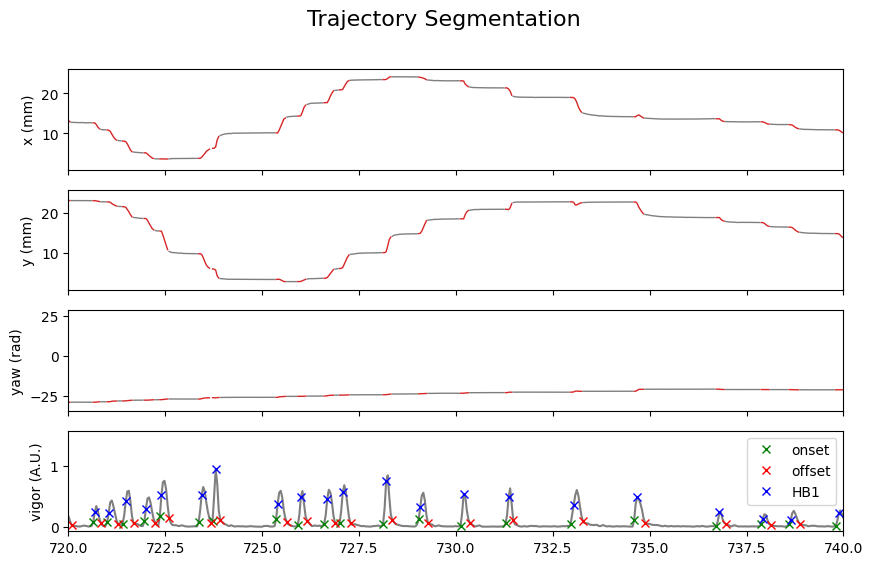

In [17]:
is_bouts = np.zeros(tracking_data.T, dtype=bool)
# Set to True for the indices within the bouts
for on_, off_ in zip(segments.onset, segments.offset):
    is_bouts[on_:off_] = True

IdSt = 18000
Duration = 20 * tracking_cfg.fps
t = np.arange(tracking_data.T) / tracking_cfg.fps

fig, ax = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
fig.suptitle("Trajectory Segmentation", fontsize=16)

traj_list = [
    traj.df.x_smooth,
    traj.df.y_smooth,
    traj.df.yaw_smooth,
]
traj_name = ["x (mm)", "y (mm)", "yaw (rad)"]
for i, (x, label_) in enumerate(zip(traj_list, traj_name)):
    x_bouts = np.where(is_bouts, x, np.nan)
    x_nobouts = np.where(~is_bouts, x, np.nan)

    ax[i].plot(t, x_nobouts, "tab:gray", lw=1)
    ax[i].plot(t, x_bouts, "tab:red", lw=1)
    ax[i].set(ylabel=label_)

ax[3].plot(t, traj.df.vigor, color="tab:gray")
ax[3].set_ylabel("vigor (A.U.)")
ax[3].plot(
    t[segments.onset], traj.df.vigor[segments.onset], "x", color="green", label="onset"
)
ax[3].plot(
    t[segments.offset], traj.df.vigor[segments.offset], "x", color="red", label="offset"
)
ax[3].plot(t[segments.HB1], traj.df.vigor[segments.HB1], "x", color="blue", label="HB1")
ax[3].legend()

ax[1].set_xlim(t[IdSt], t[IdSt + Duration])
plt.show()

* Let's display the trajectory of the bouts classified with a probability greater than 70%:

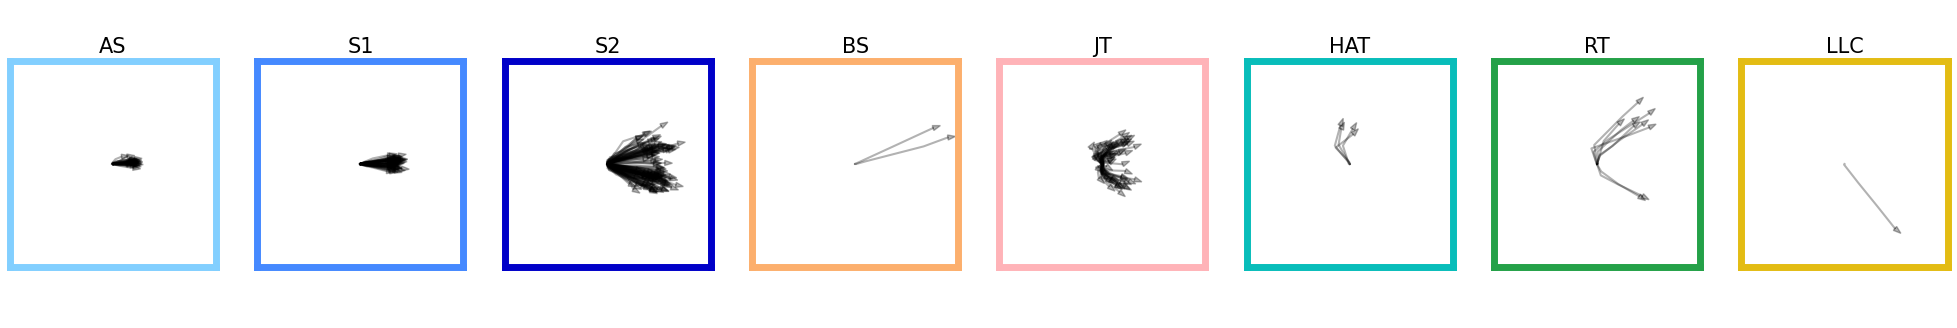

In [35]:
traj_array = segments.extract_traj_array(
    head_x=traj.df.x_smooth,
    head_y=traj.df.y_smooth,
    head_angle=traj.df.yaw_smooth,
    align_to_onset=True,
)

id_b = np.unique(bouts.df.label.category[bouts.df.label.proba > 0.7]).astype("int")

fig, ax = plt.subplots(facecolor="white", figsize=(25, 4))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

G = gridspec.GridSpec(1, len(id_b))
ax0 = {}
for i, b in enumerate(id_b):
    ax0 = plt.subplot(G[i])
    ax0.set_title(bouts_category_name_short[b], fontsize=15)
    id = bouts.df[(bouts.df.label.category == b) & (bouts.df.label.proba > 0.7)].index
    if len(id) > 0:
        for i in id:
            ax0.plot(traj_array[i, 0, :], traj_array[i, 1, :], color="k", alpha=0.3)
            ax0.arrow(
                traj_array[i, 0, -1],
                traj_array[i, 1, -1],
                0.01 * np.cos(traj_array[i, 2, -1]),
                0.01 * np.sin(traj_array[i, 2, -1]),
                width=0.005,
                head_width=0.2,
                color="k",
                alpha=0.3,
            )
    ax0.set_aspect(1)
    ax0.set(xlim=(-4, 4), ylim=(-4, 4))
    ax0.set_xticks([])
    ax0.set_yticks([])
    for sp in ["top", "bottom", "left", "right"]:
        ax0.spines[sp].set_color(bouts_category_color[b])
        ax0.spines[sp].set_linewidth(5)

plt.show()

* Finally, we can display a sample ethogram:

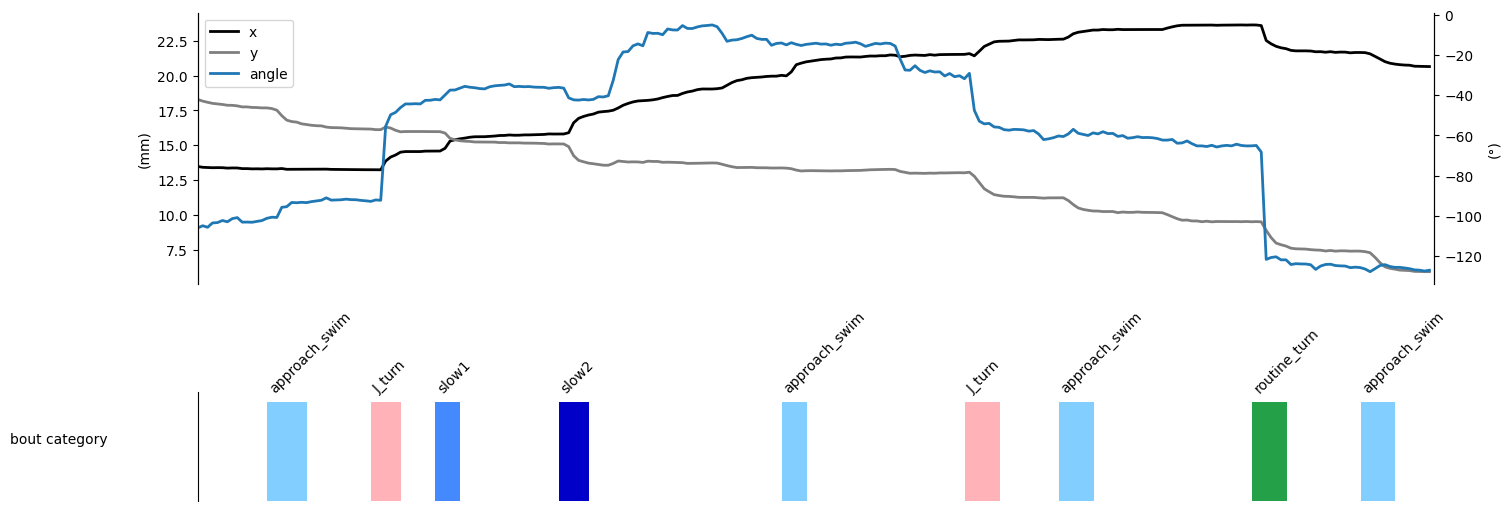

In [40]:
IdSt, T = 20000, 10
Duration = T * tracking_cfg.fps
IdEd = IdSt + Duration - 1
t = np.arange(Duration) / tracking_cfg.fps

data = ethogram.df.loc[IdSt:IdEd]
x_data = data[("trajectory", "x")].values
y_data = data[("trajectory", "y")].values
angle_data = data[("trajectory", "angle")].values
bout_cat_data = data[("bout", "cat")].values
bout_id_data = data[("bout", "id")].values

valid_data = ~np.isnan(angle_data)
unwrapped = np.copy(angle_data)
unwrapped[valid_data] = np.unwrap(angle_data[valid_data])
angle_data = 180 / np.pi * unwrapped

fig, (ax1, ax) = plt.subplots(
    2,
    1,
    figsize=(15, 5),
    gridspec_kw={"height_ratios": [1, 0.4], "hspace": 0.1},
    facecolor="white",
    constrained_layout=True,
)
ax2 = ax1.twinx()

ax1.plot(t, x_data, lw=2, color="k", label="x")
ax1.plot(t, y_data, lw=2, color="tab:gray", label="y")
ax1.set_ylabel("(mm)")
ax2.plot(t, angle_data, lw=2, color="tab:blue", label="angle")
ax2.set_ylabel("(°)")

for spine in ["top", "bottom"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
ax1.set_xlim(0, T)
ax1.get_xaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])
ax1.set_xlim(0, T)
# Add both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")


ax.imshow(
    bout_cat_data.reshape(1, -1),
    cmap=cmp_bouts,
    aspect="auto",
    vmin=0,
    vmax=12,
    interpolation="nearest",
    extent=(0, T, 0, 1),
)
for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.set_xlim(0, T)
ax.set_ylim(0, 1.1)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

for i in np.unique(bout_id_data[bout_id_data > -1]).astype("int"):
    on_, b = (
        bouts.df.iloc[i][("location", "onset")],
        bouts.df.iloc[i][("label", "category")],
    )
    ax.text(
        (on_ - IdSt) / tracking_cfg.fps, 1.1, bouts_category_name[int(b)], rotation=45
    )

ax.set_ylabel("bout category", rotation=0, labelpad=100)
plt.show()